In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, recall_score, f1_score

from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('D:/Workspace/BTL_IoT/heart_dataset.csv')

data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
data = data.drop("id", axis=1)

data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
data["age"] = np.round(data["age"] / 365)
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.0,2,168,62.0,110,80,1,1,0,0,1,0
1,55.0,1,156,85.0,140,90,3,1,0,0,1,1
2,52.0,1,165,64.0,130,70,3,1,0,0,0,1
3,48.0,2,169,82.0,150,100,1,1,0,0,1,1
4,48.0,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
data.tail()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
69995,53.0,2,168,76.0,120,80,1,1,1,0,1,0
69996,62.0,1,158,126.0,140,90,2,2,0,0,1,1
69997,52.0,2,183,105.0,180,90,3,1,0,1,0,1
69998,61.0,1,163,72.0,135,80,1,2,0,0,0,1
69999,56.0,1,170,72.0,120,80,2,1,0,0,1,0


In [6]:
data["gender"] = np.where(data["gender"] == 1, 0, 1)
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.0,1,168,62.0,110,80,1,1,0,0,1,0
1,55.0,0,156,85.0,140,90,3,1,0,0,1,1
2,52.0,0,165,64.0,130,70,3,1,0,0,0,1
3,48.0,1,169,82.0,150,100,1,1,0,0,1,1
4,48.0,0,156,56.0,100,60,1,1,0,0,0,0


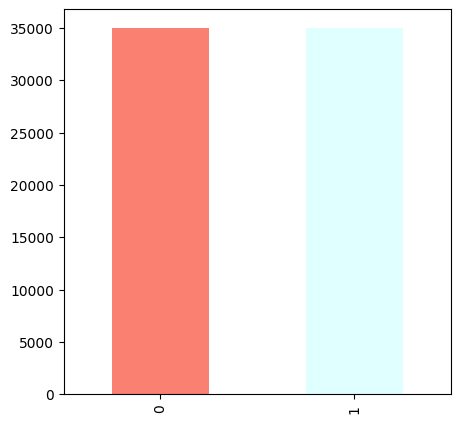

In [7]:
data["cardio"].value_counts().plot.bar(color=("salmon","lightcyan"), figsize=(5,5));

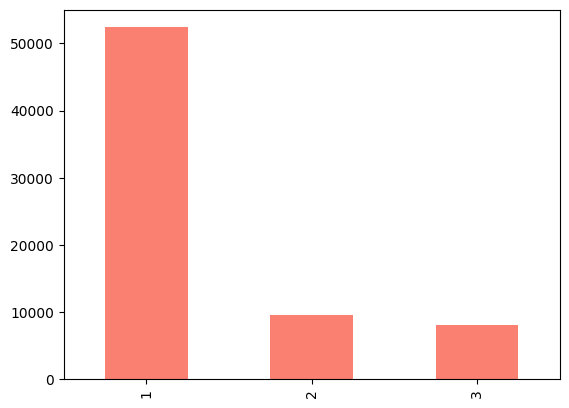

In [8]:
data["cholesterol"].value_counts().plot.bar(color="salmon");

In [9]:
pd.crosstab(data["cardio"], data["cholesterol"])

cholesterol,1,2,3
cardio,,,
0,29330,3799,1892
1,23055,5750,6174


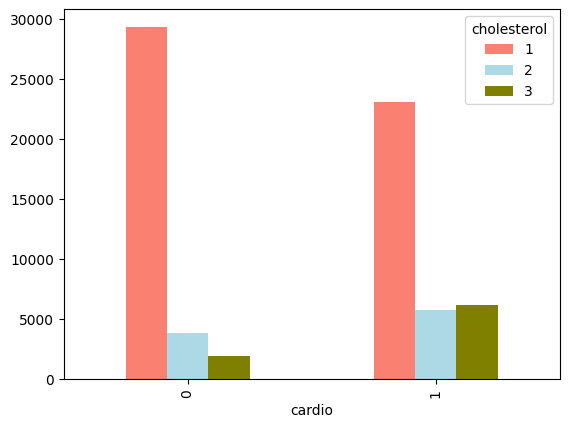

In [10]:
pd.crosstab(data["cardio"], data["cholesterol"]).plot(kind="bar",
                                                      color=("Salmon", "lightblue", "olive"));

In [11]:
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.0,1,168,62.0,110,80,1,1,0,0,1,0
1,55.0,0,156,85.0,140,90,3,1,0,0,1,1
2,52.0,0,165,64.0,130,70,3,1,0,0,0,1
3,48.0,1,169,82.0,150,100,1,1,0,0,1,1
4,48.0,0,156,56.0,100,60,1,1,0,0,0,0


In [12]:
pd.crosstab(data["cardio"], data["alco"])

alco,0,1
cardio,,
0,33080,1941
1,33156,1823


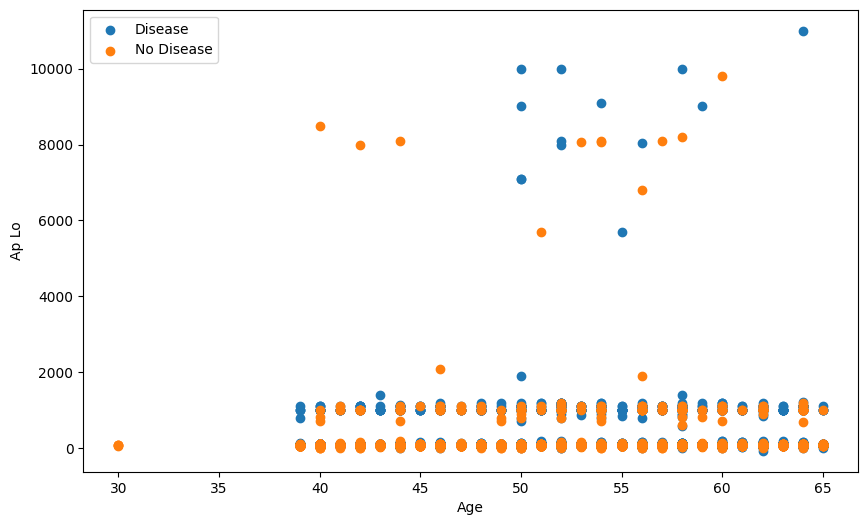

In [13]:
plt.figure(figsize=(10,6))

plt.scatter(data.age[data["cardio"]==1],
            data.ap_lo[data["cardio"]==1])

plt.scatter(data.age[data["cardio"]==0],
            data.ap_lo[data["cardio"]==0]);

plt.xlabel("Age");
plt.ylabel("Ap Lo");
plt.legend(["Disease", "No Disease"]);

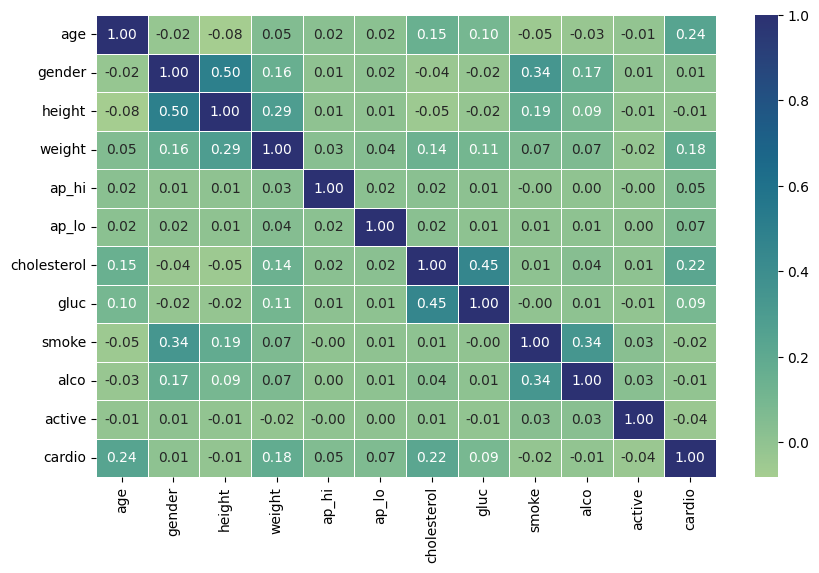

In [14]:
corr_matrix = data.corr()

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.heatmap(corr_matrix, annot=True, linewidths=0.5,  fmt=".2f", cmap="crest");

In [15]:
data.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [16]:
X = data.drop("cardio", axis=1)
y = data["cardio"]

len(X), len(y)

(70000, 70000)

In [17]:
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
models = {
    "Linear Regression": LinearRegression(),
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    # "Decision Tree": DecisionTreeClassifier(),
}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    
    model_scores = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        
        model_scores[name] = model.score(X_test, y_test)
        
    return model_scores

In [19]:
models_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
models_scores

c:\Users\FPT Shop\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Linear Regression': 0.12768423502631543,
 'Logistic Regression': 0.7135714285714285,
 'KNN': 0.6872857142857143}

In [20]:
train_scores = []
test_scores = []


neighbors = range(1,21)
# Knn
knn_clf = KNeighborsClassifier()


for i in neighbors:
    
    knn_clf.set_params(n_neighbors=i)
    
    knn_clf.fit(X_train, y_train)
    
    train_scores.append(knn_clf.score(X_train, y_train))
    
    test_scores.append(knn_clf.score(X_test, y_test))

In [21]:
train_scores

[0.97325,
 0.810625,
 0.8144107142857143,
 0.7772321428571428,
 0.7797142857142857,
 0.7626428571428572,
 0.7663928571428571,
 0.7559642857142858,
 0.7568571428571429,
 0.7506785714285714,
 0.7515178571428571,
 0.7473928571428572,
 0.7477857142857143,
 0.7444642857142857,
 0.7452678571428571,
 0.7427857142857143,
 0.7430892857142857,
 0.742125,
 0.7414821428571429,
 0.7403571428571428]

In [22]:
test_scores

[0.633,
 0.6347857142857143,
 0.6696428571428571,
 0.6720714285714285,
 0.6872857142857143,
 0.6933571428571429,
 0.6994285714285714,
 0.7038571428571428,
 0.7052142857142857,
 0.7077857142857142,
 0.707,
 0.7101428571428572,
 0.7106428571428571,
 0.7116428571428571,
 0.7143571428571428,
 0.7151428571428572,
 0.7143571428571428,
 0.7145,
 0.7150714285714286,
 0.7167142857142857]

KNN : 71.67%


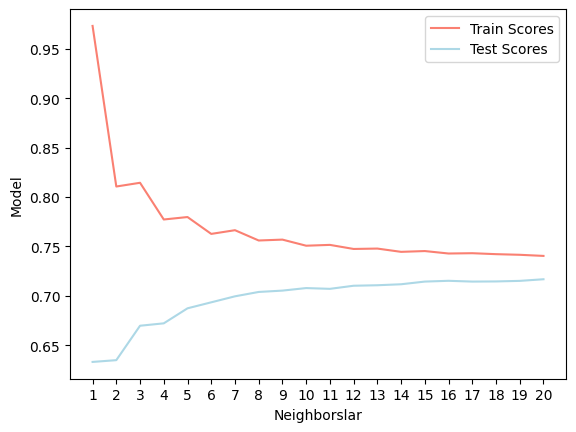

In [23]:
plt.plot(neighbors,train_scores, color="salmon", label="Train Scores");
plt.plot(neighbors,test_scores, color="lightblue", label="Test Scores");

plt.xlabel("Neighborslar")
plt.ylabel("Model")
plt.xticks(np.arange(1,21,1))
plt.legend();

print(f"KNN : {max(test_scores)*100:.2f}%")